In [1]:
from tools import *

In [2]:
def logpdfTarget (x, mu, sigma_inverse):
    lnp = -(1/2) * ((x-mu).T).dot(sigma_inverse).dot((x-mu))
    return(lnp)

In [3]:
np.random.seed(12)
d = 1000
mu = np.zeros(d)
sigma_inverse = wishart.rvs(df=d,scale=np.eye(d))
true_sigma = np.linalg.inv(sigma_inverse)
print(np.sum(abs(true_sigma)>0.99)/2,'|',round((np.sum(abs(true_sigma)>0.99)/2)/((d*(d-1))/2),2))
np.set_printoptions(suppress=True)
np.matrix.round(true_sigma,2)

137815.0 | 0.28


array([[ 0.41, -0.06, -0.24, ...,  0.13,  0.46,  0.45],
       [-0.06,  1.57,  0.81, ..., -1.01, -0.61, -0.7 ],
       [-0.24,  0.81,  0.68, ..., -0.68, -0.63, -0.6 ],
       ...,
       [ 0.13, -1.01, -0.68, ...,  1.31,  0.78,  0.85],
       [ 0.46, -0.61, -0.63, ...,  0.78,  1.06,  0.89],
       [ 0.45, -0.7 , -0.6 , ...,  0.85,  0.89,  1.05]])

In [4]:
nround = 40000; K=3000
result = np.zeros(K*nround*d, dtype=np.float16).reshape(K,nround,d)

#Step1: Setting the Initialization
theta_old = np.random.uniform(-1,1,size=K*d).reshape(K,d)
logpdf_old = [logpdfTarget(theta_old[i,:],mu,sigma_inverse) for i in range(K)]
#Step2: Setting the tuning parameters ndarrays
sigma = 2.38/(2*np.sqrt(d)) * 1.58
eplison = np.random.uniform(-0.0001,0.0001,size=nround*K).reshape(nround,K)
# Other time/acceptance couting variable intialization
begin_loop = time.time(); accept = 0; update = 1000; burnin=2000

for i in range(nround):
    if (i % update == 0) and (i>0):
        accept_rate = accept/(i*K)
        print(int(i/update),'/',int(nround/update), '  Acep%:',round(accept_rate,3) ,
              '  Sigma%:',round(sigma,3) ,'  Time:',round(time.time()-begin_loop,2),'s',sep='')
        sigma = sigma * math.tan(math.pi/2*accept_rate) / math.tan(math.pi/2*0.23)
    for k in range(K):
        chain_sample = list(range(K)); chain_sample.pop(k)
        m,n = random.sample(chain_sample,2)
        theta_new = theta_old[k,:] + sigma * (theta_old[m,:] - theta_old[n,:]) + eplison[i,k]
        logpdf_new = logpdfTarget(theta_new,mu,sigma_inverse)
        pi_dif = logpdf_new - logpdf_old[k]
        
        if ((pi_dif>0) | (np.exp(pi_dif)>np.random.random())):
            theta_old[k,:] = theta_new
            logpdf_old[k] = logpdf_new
            accept += 1
        result[k,i,:] = theta_old[k,:]

print('总共用时: %f'% (time.time()-begin_loop), "|", 'Acet Rate:', accept/(nround*K))

1/40  Acep%:0.138  Sigma%:0.059  Time:540.25s
2/40  Acep%:0.186  Sigma%:0.035  Time:1081.36s
3/40  Acep%:0.214  Sigma%:0.028  Time:1622.57s
4/40  Acep%:0.23  Sigma%:0.026  Time:2163.94s
5/40  Acep%:0.239  Sigma%:0.026  Time:2704.96s
6/40  Acep%:0.243  Sigma%:0.027  Time:3248.36s
7/40  Acep%:0.245  Sigma%:0.028  Time:3793.35s
8/40  Acep%:0.244  Sigma%:0.03  Time:4338.5s
9/40  Acep%:0.243  Sigma%:0.032  Time:4883.08s
10/40  Acep%:0.241  Sigma%:0.034  Time:5429.32s
11/40  Acep%:0.238  Sigma%:0.036  Time:5974.55s
12/40  Acep%:0.237  Sigma%:0.038  Time:6519.79s
13/40  Acep%:0.235  Sigma%:0.039  Time:7065.06s
14/40  Acep%:0.235  Sigma%:0.04  Time:7610.09s
15/40  Acep%:0.235  Sigma%:0.041  Time:8154.85s
16/40  Acep%:0.236  Sigma%:0.042  Time:8711.09s
17/40  Acep%:0.238  Sigma%:0.043  Time:9256.78s
18/40  Acep%:0.239  Sigma%:0.045  Time:9802.13s
19/40  Acep%:0.24  Sigma%:0.047  Time:10347.67s
20/40  Acep%:0.241  Sigma%:0.049  Time:10893.68s
21/40  Acep%:0.241  Sigma%:0.052  Time:11439.29s
22/4

In [52]:
burnin=20000
after_mixing = result[:,burnin:,:]
print('Dimension after mixing but before stacking:',after_mixing.shape)
stack_res = after_mixing.reshape(K*(nround-burnin),d)
print('Dimension after stacking:',stack_res.shape)

Dimension after mixing but before stacking: (3000, 20000, 1000)
Dimension after stacking: (60000000, 1000)


In [51]:
Eff_set = []; dim = 10
for i in range(dim):
    eff = Eff_Mean_BM(combine_res[:,i])
    Eff_set.append(eff)
    print('Efficiency of %d dimension:' % i,round(eff,5))
print('Average efficiency of first %d dimensions:' % dim, round(np.mean(Eff_set),5))

Efficiency of 0 dimension: 0.00095
Efficiency of 1 dimension: 0.00025
Efficiency of 2 dimension: 0.00058
Efficiency of 3 dimension: 9e-05
Efficiency of 4 dimension: 7e-05
Efficiency of 5 dimension: 0.00086
Efficiency of 6 dimension: 0.00033
Efficiency of 7 dimension: 6e-05
Efficiency of 8 dimension: 0.00038
Efficiency of 9 dimension: 0.0009
Average efficiency of first 10 dimensions: 0.00045


In [69]:
estimated_mean = np.mean(combine_res,axis=0,dtype=np.float64)
restric_dim = d
estimated_cov = np.cov(stack_res[:60000000,:restric_dim].T)
print("Estimated Covaricne Matirx:")
print(np.matrix.round(estimated_cov,3))
print('------------------------------------------------')
print("Discrepency")
abs_mat = abs(estimated_cov-true_sigma[:restric_dim,:restric_dim])
print(np.sum(abs_mat),"|", np.sum(abs_mat)/(np.sum(abs(true_sigma[:restric_dim,:restric_dim]))))
print('------------------------------------------------')
print("True Covaricne Matirx:")
print(np.matrix.round(true_sigma[:restric_dim,:restric_dim],3))

Estimated Covaricne Matirx:
[[ 0.42  -0.061 -0.25  ...  0.14   0.467  0.457]
 [-0.061  1.608  0.83  ... -1.035 -0.621 -0.722]
 [-0.25   0.83   0.692 ... -0.699 -0.65  -0.612]
 ...
 [ 0.14  -1.035 -0.699 ...  1.343  0.802  0.874]
 [ 0.467 -0.621 -0.65  ...  0.802  1.092  0.914]
 [ 0.457 -0.722 -0.612 ...  0.874  0.914  1.08 ]]
------------------------------------------------
Discrepency
18735.233529695815 | 0.023163252818287617
------------------------------------------------
True Covaricne Matirx:
[[ 0.415 -0.056 -0.245 ...  0.13   0.455  0.447]
 [-0.056  1.574  0.81  ... -1.014 -0.608 -0.704]
 [-0.245  0.81   0.676 ... -0.68  -0.634 -0.597]
 ...
 [ 0.13  -1.014 -0.68  ...  1.309  0.778  0.848]
 [ 0.455 -0.608 -0.634 ...  0.778  1.064  0.891]
 [ 0.447 -0.704 -0.597 ...  0.848  0.891  1.052]]


In [64]:
np.save('Cov_matrix_EM_MCMC_1000d.npy',estimated_cov)
np.save('Mean_EM_MCMC_1000d.npy',estimated_mean)

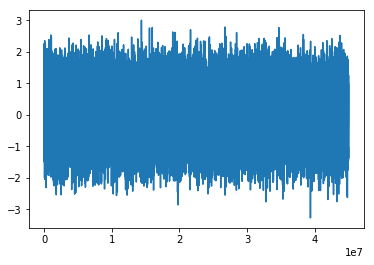

In [12]:
plt.plot(stack_res[:45000000,0])
# plt.xlim(0,2000)
plt.show()

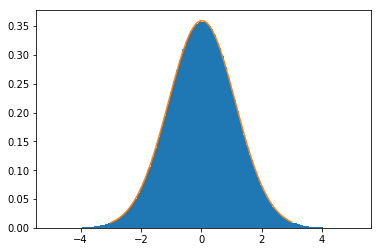

In [43]:
index = random.sample(range(d),1)
xindex = np.arange(-3,3,0.001)
mean = np.mean(stack_res[:,index])
sd = np.std(stack_res[:,index],dtype=np.float64)
yindex = scipy.stats.norm.pdf(xindex,loc=mean,scale=sd)
plt.hist(stack_res[:,index],bins=200,density=True)
plt.plot(xindex,yindex)
plt.show()